# XGBoost to predict discharge disability: Are the probabilities organised?
Do the probabilities rise and fall around the max, or are the probabilities more disorganised - is the pattern different for patient cohorts?


## Plain English summary
Does the output for the patents probability for each mRS output change linearly across the mRS levels? Investigate this for all patients in k-fold 1.\
Examine the pattern of the probabilites given to each class for each instance - do they rise and fall around the maximum?

## Model and data
Model: XGBoost classifier (multiclass classification) [from notebook 010]\
Target feature: Discharge disability\
Input features: All the relevant features in SSNAP\
Kfold split: First kfold split\
[SHAP values from notebook 011]

## Aims
Examine the pattern of the probabilites given to each class for each instance - do they rise and fall around the maximum?\
Use the number of inflection points to determine the pattern of the probabilities across the mRS levels. Having 1 or fewer inflection points means that the mRS probabilities are linear (maybe around a mid point). Having more that 1 inflection point means that the mRS probabilities go up and down across the full mRS scale.

## Observations
The output for the patents probability for each mRS output did not change linearly across the mRS levels.

* There are 21359 patients with 0 inflection points on the graph (13.6%)
* There are 47081 patients with 1 inflection points on the graph (30.0%)
* There are 70871 patients with 2 inflection points on the graph (45.2%)
* There are 7405 patients with 3 inflection points on the graph (4.7%)
* There are 9966 patients with 4 inflection points on the graph (6.4%)
* There are 165 patients with 5 inflection points on the graph (0.1%)

* Having 1 or fewer inflection points means that the mRS probabilities are linear (maybe around a mid point): 68440 patients (43.6%)
* Having more that 1 inflection point means that the mRS probabilities go up and down across the full mRS scale: 88407 patients (56.4)%

* These proportions shift slightly towards fewer inflection points in the cohort of patients that are correctly classified (vs incorrectly classified).

## Further work
Learning curves: How much data do we need? Do we have enough? Notebook 015.

## Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb

(code orignially from 01a_xgb_kfold_all_features_accuracy_importance_shap.ipynb and 01_xgb_5fold_all_features_accuracy_importance_shap.ipynb)

(based on notebook 01b_xgb_kfold_all_features_multiclass_probability_pattern.ipynb: Taking copy of 230623 (training model with default learning rate of 0.3, using onset to thrombolysis, using -100 when not have thrombolysis)

## Import libraries

In [100]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import math

import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dataclasses import dataclass

import pickle

from os.path import exists

import time
import datetime

Report the time duration to run notebook

In [101]:
start_time = time.time()

Choose the single kfold split to use

In [102]:
k = 0

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [103]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_all_features_kfold{k}'
    notebook: str = '014_'

paths = Paths()

Create output folders if needed

In [104]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

Some features need to be removed from the dataset (those that are duplicates). Define a function to do this.

In [105]:
def drop_columns(df, cols):
    """
    For the dataframe, remove the columns 'cols' if they are present
    
    Args:
        df [dataframe]: The feature values per patient
        cols [list]: The features to remove if present

    Return:
        df [dataframe]: The feature values per patient without specified columns
    """
    for col in cols:
        if col in df.columns: df.drop([col],axis=1,inplace=True)
    return(df)

Specify the columns to remove

In [106]:
cols_remove = ['id','stroke_team_id']

## Import data
Data has previously been split into 5 stratified k-fold splits. Read these in.

In [107]:
# Read in training set, restrict to chosen features
filename = os.path.join(paths.data_read_path, 
                        ('03_train_' + str(k) + '.csv'))
train_data = pd.read_csv(filename)
train_data = drop_columns(train_data, cols_remove)

# Read in training set, restrict to chosen features
filename = os.path.join(paths.data_read_path, 
                        ('03_test_' + str(k) + '.csv'))
test_data = pd.read_csv(filename)
test_data = drop_columns(test_data, cols_remove)

In [108]:
class_names = train_data['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)

In [109]:
n_patients = test_data.shape[0]

## One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [110]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [111]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, convert to one hot encoded

In [112]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    train_data = convert_feature_to_one_hot(train_data, feature, prefix)
    test_data = convert_feature_to_one_hot(test_data, feature, prefix)

Get X and y

In [113]:
X_train = train_data.drop('discharge_disability', axis=1)
X_test = test_data.drop('discharge_disability', axis=1)
y_train = train_data['discharge_disability']
y_test = test_data['discharge_disability']

## Load XGBoost model

Get probabilities of each mRS score for each patient.

In [114]:
# Model filename
filename = os.path.join(paths.model_save_path, 
                        ('010_xgb_all_features_5fold_' + str(k) + '.p'))

# Check if exists
file_exists = exists(filename)

if file_exists:
# Load models
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)
else:
    print('Run notebook 010 first. Using the model that was trained there')

# Get target categories from model
classes = model.classes_

# Get predicted probabilities
y_probs = model.predict_proba(X_test)

# Get predicted class
y_pred = model.predict(X_test)

Per patient, have the probability of being each mRS label.

Interested whether the probability is linear across the mRS levels, or whether there are some up and downs.

For all patients, calculate the number of inflection points.

A point of inflection is where the graph of a function changes concavity. This is where the second derivative of function changes sign (from negative to positive, or vice-versa).

If a function has 0 or 1 inflection points, then the probability of the mRS has at most a single change, and so falls linearly around the highest point.

If a function has 2 or more inflection points, then the probabiliy changes more randomly across the mRS levels.

My initial appraoch was to use the second derivative, but took a more first principles approach - around each point see whether the neighbouring points made it an inflection).

Set a buffer value so that this needs to be exceeded to be classified as a change in direction. Such as, an inflection only counted if change in probability is >0.01 (1%)

In [115]:
# Set the min difference that qualifies as a change in direction
buffer = 0.01

# Initialise a series to store the number of inflections per patient
n_inflection_points = pd.Series(0, index=np.arange(n_patients), 
                                name='n_inflections')

for c in range(1,6):
    mask_hill = ((y_probs[:,c-1] - y_probs[:,c] > buffer) & 
                 (y_probs[:,c] - y_probs[:,c+1]<-buffer))
    mask_trough = ((y_probs[:,c-1] - y_probs[:,c] < -buffer) & 
                   (y_probs[:,c] - y_probs[:,c+1]>buffer))

    n_inflection_points = n_inflection_points + mask_hill + mask_trough

View a plot of the probabilities of the multiclassification for the first four patients, and report the number of inflection points as calculated above.

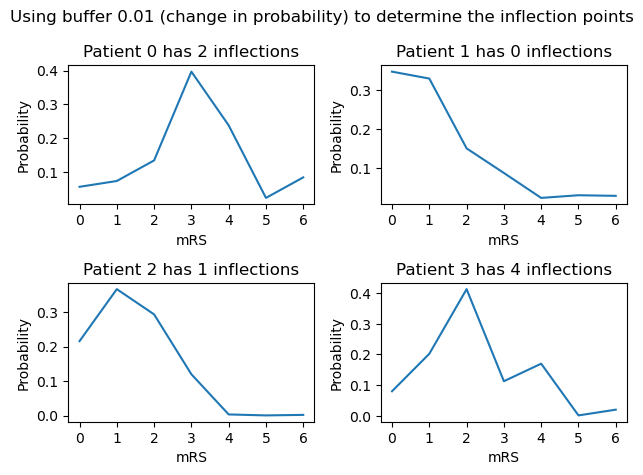

In [116]:
fig, axes = plt.subplots(2,2)
fig.suptitle(f"Using buffer {buffer} (change in probability) to determine the inflection points")
axes = axes.ravel()
for p in range(4):
    axes[p].plot([0,1,2,3,4,5,6],y_probs[p,:])
    axes[p].set_title(f"Patient {p} has {n_inflection_points[p]} inflections")
    axes[p].set_xticks(np.arange(0, 7, 1))
    axes[p].set_xlabel("mRS")
    axes[p].set_ylabel("Probability")
plt.tight_layout()
plt.show()

Report an overview of number of patients with each number of inflection points.

In [117]:
def results_overview(n_inflection_points):
    """
    
    Args:
        n_inflection_points [series]:

    Return:
        list_patients_correct [list]:
    """
    list_patients_correct = []
    n_patients = n_inflection_points.shape[0]
    for i in range(6):
        x = (n_inflection_points == i).sum()
        print (f"There are {x} patients with {i} "
            f"inflection points on the graph ({round(x/n_patients,3)*100}%)")
        list_patients_correct.append(x)
    print()

    x = (n_inflection_points <2).sum()
    print (f"Having 1 or fewer inflection points means that the mRS probabilities "
        f"are linear (maybe around a mid point). "
        f"({x} patients ({round(x/n_patients,3)*100}%)")
    x = (n_inflection_points >1).sum()
    print(f"Having more that 1 inflection point means that the mRS probabilities "
        f"go up and down across the full mRS scale. "
        f"({x} patients ({round(x/n_patients,3)*100})%")
    return(list_patients_correct)

In [118]:
results_overview(n_inflection_points)

There are 4567 patients with 0 inflection points on the graph (13.600000000000001%)
There are 12273 patients with 1 inflection points on the graph (36.5%)
There are 11733 patients with 2 inflection points on the graph (34.8%)
There are 2475 patients with 3 inflection points on the graph (7.3999999999999995%)
There are 2523 patients with 4 inflection points on the graph (7.5%)
There are 99 patients with 5 inflection points on the graph (0.3%)

Having 1 or fewer inflection points means that the mRS probabilities are linear (maybe around a mid point). (16840 patients (50.0%)
Having more that 1 inflection point means that the mRS probabilities go up and down across the full mRS scale. (16830 patients (50.0)%


[4567, 12273, 11733, 2475, 2523, 99]

### Look at subgroups of patients

##### Subgroup 1: Patients that are correctly predicted, versus those that are not. 
Is the model more certain for the patients that it got correct?

In [119]:
mask_correct = y_pred == y_test
patients_correct = mask_correct.sum()
print(f"{patients_correct} patients are correctly classified "
      f"({round(patients_correct/n_patients*100, 3)}%)")
print()
print("Results:")
list_patients_correct = results_overview(n_inflection_points[mask_correct])
print()
print("***")
print()
mask_incorrect = y_pred != y_test
patients_incorrect = mask_incorrect.sum()
print(f"{patients_incorrect} patients incorrectly classified "
      f"({round(patients_incorrect/n_patients*100, 3)}%))")
print()
print("Results:")
list_patients_incorrect = results_overview(n_inflection_points[mask_incorrect])

14811 patients are correctly classified (43.989%)

Results:
There are 2510 patients with 0 inflection points on the graph (16.900000000000002%)
There are 5802 patients with 1 inflection points on the graph (39.2%)
There are 4774 patients with 2 inflection points on the graph (32.2%)
There are 867 patients with 3 inflection points on the graph (5.8999999999999995%)
There are 830 patients with 4 inflection points on the graph (5.6000000000000005%)
There are 28 patients with 5 inflection points on the graph (0.2%)

Having 1 or fewer inflection points means that the mRS probabilities are linear (maybe around a mid point). (8312 patients (56.10000000000001%)
Having more that 1 inflection point means that the mRS probabilities go up and down across the full mRS scale. (6499 patients (43.9)%

***

18859 patients incorrectly classified (56.011%))

Results:
There are 2057 patients with 0 inflection points on the graph (10.9%)
There are 6471 patients with 1 inflection points on the graph (34.300

Create a nested pie chart (proportion of correct on the outside, and proportion of incorrect on the inside, with each number ofr inflection points)

https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/nested_pie.html#sphx-glr-gallery-pie-and-polar-charts-nested-pie-py

Create own colormap to ensure enough colours for the 5 inflection points, for the number of patient subgroups.

In [120]:
def generate_colormap(number_of_distinct_colors: int = 80):
    if number_of_distinct_colors == 0:
        number_of_distinct_colors = 80

    number_of_shades = 7
    number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)

    # Create an array with uniformly drawn floats taken from <0, 1) partition
    linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades

    # We are going to reorganise monotonically growing numbers in such way that there will be single array with saw-like pattern
    #     but each saw tooth is slightly higher than the one before
    # First divide linearly_distributed_nums into number_of_shades sub-arrays containing linearly distributed numbers
    arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

    # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
    arr_by_shade_columns = arr_by_shade_rows.T

    # Keep number of saw teeth for later
    number_of_partitions = arr_by_shade_columns.shape[0]

    # Flatten the above matrix - join each row into single array
    nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)

    # HSV colour map is cyclic (https://matplotlib.org/tutorials/colors/colormaps.html#cyclic), we'll use this property
    initial_cm = hsv(nums_distributed_like_rising_saw)

    lower_partitions_half = number_of_partitions // 2
    upper_partitions_half = number_of_partitions - lower_partitions_half

    # Modify lower half in such way that colours towards beginning of partition are darker
    # First colours are affected more, colours closer to the middle are affected less
    lower_half = lower_partitions_half * number_of_shades
    for i in range(3):
        initial_cm[0:lower_half, i] *= np.arange(0.2, 1, 0.8/lower_half)

    # Modify second half in such way that colours towards end of partition are less intense and brighter
    # Colours closer to the middle are affected less, colours closer to the end are affected more
    for i in range(3):
        for j in range(upper_partitions_half):
            modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
            modifier = j * modifier / upper_partitions_half
            initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

    return ListedColormap(initial_cm)


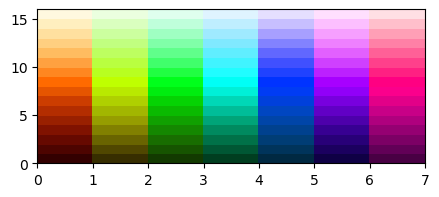

In [121]:
N = 16
M = 7
H = np.arange(N*M).reshape([N,M])
fig = plt.figure(figsize=(5, 2))
ax = plt.pcolor(H, cmap=generate_colormap(N*M))
plt.show()

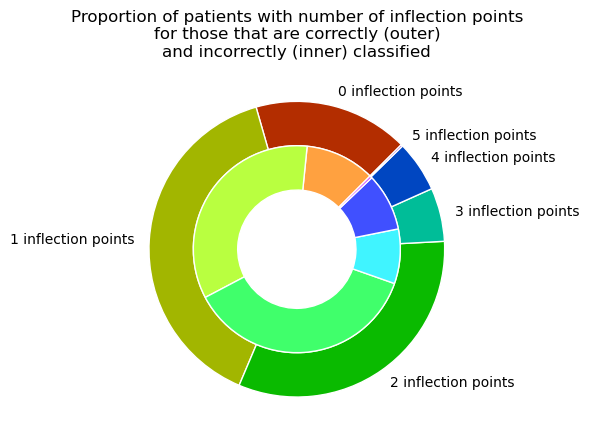

In [122]:
fig, ax = plt.subplots()

size = 0.3

max_infection_points = max(len(list_patients_correct), len(list_patients_incorrect))
labels = [(str(i) + " inflection points")for i in range(max_infection_points)]
list_data = [list_patients_correct, list_patients_incorrect]
list_titles = ["Patients correctly classified", "Patients incorrectly classified"]

N = 16
M = 7
cmap = generate_colormap(N*M)
colour_array = np.arange(max_infection_points)
outer_colors = cmap(colour_array + (M * 5))
inner_colors = cmap(colour_array + (M * 10))

ax.pie(list_data[0], radius=1, colors=outer_colors, startangle=45, 
       labels=labels, wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(list_data[1], radius=1-size, colors=inner_colors, startangle=45,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", 
       title=('Proportion of patients with number of inflection points\nfor '
              'those that are correctly (outer)\nand incorrectly (inner) classified'))
plt.show()

##### Subgroup 2: Patients that are in each mRS class (observed)
Is the model more certain for the patients that are observed as a certain discharge disability?

In [123]:
list_patients_class_observed = []

for c in range(n_classes):
    mask_class = y_test == c
    patients_class = mask_class.sum()
    print(f"{patients_class} patients are observed in class {c} "
        f"({round(patients_class/n_patients*100, 3)}%)")
    print()
    print("Results:")
    list_patients_class = results_overview(n_inflection_points[mask_class])
    print()
    print("***")
    print()
    list_patients_class_observed.append(list_patients_class)

4295 patients are observed in class 0 (12.756%)

Results:
There are 1305 patients with 0 inflection points on the graph (30.4%)
There are 1412 patients with 1 inflection points on the graph (32.9%)
There are 1029 patients with 2 inflection points on the graph (24.0%)
There are 361 patients with 3 inflection points on the graph (8.4%)
There are 181 patients with 4 inflection points on the graph (4.2%)
There are 7 patients with 5 inflection points on the graph (0.2%)

Having 1 or fewer inflection points means that the mRS probabilities are linear (maybe around a mid point). (2717 patients (63.3%)
Having more that 1 inflection point means that the mRS probabilities go up and down across the full mRS scale. (1578 patients (36.7)%

***

7103 patients are observed in class 1 (21.096%)

Results:
There are 746 patients with 0 inflection points on the graph (10.5%)
There are 3378 patients with 1 inflection points on the graph (47.599999999999994%)
There are 1951 patients with 2 inflection point

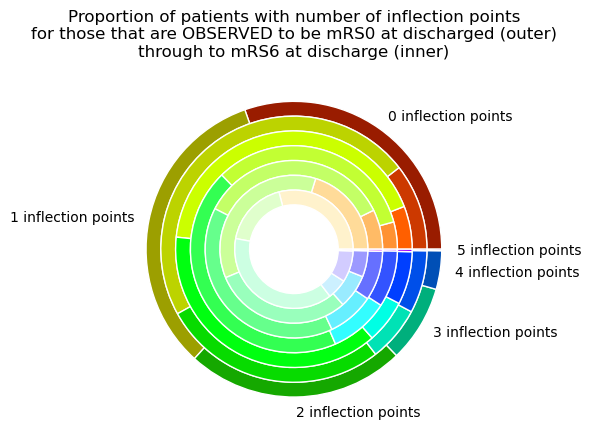

In [124]:
fig, ax = plt.subplots()

size = 0.1

max_infection_points = 6
labels = [(str(i) + " inflection points") for i in range(max_infection_points)]
list_titles = ["mRS0", "mRS1", "mRS2", "mRS3", "mRS4", "mRS5", "mRS6"]

N = n_classes * 1.2
M = 7
cmap = generate_colormap(N*M)
colour_array = np.arange(max_infection_points)

for c in range(n_classes):
    colors = cmap(colour_array  + (M * (c + 2)))

    if c == 0:   
       ax.pie(list_patients_class_observed[c], radius=1-(size*c), colors=colors, 
              labels=labels, wedgeprops=dict(width=size, edgecolor='w'))
    else:
       ax.pie(list_patients_class_observed[c], radius=1-(size*c), colors=colors, 
              wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", 
       title=('Proportion of patients with number of inflection points\nfor '
              'those that are OBSERVED to be mRS0 at discharged (outer)\n'
              'through to mRS6 at discharge (inner)'))
plt.show()

##### Subgroup 3: Patients that are in each mRS class (predictedd)
Is the model more certain for the patients that are predicted as a certain discharge disability?

In [125]:
list_patients_class_predicted = []

for c in range(n_classes):
    mask_class = y_pred == c
    patients_class = mask_class.sum()
    print(f"{patients_class} patients are predicted to be in class {c} "
        f"({round(patients_class/n_patients*100, 3)}%)")
    print()
    print("Results:")
    list_patients_class = results_overview(n_inflection_points[mask_class])
    print()
    print("***")
    print()
    list_patients_class_predicted.append(list_patients_class)

3844 patients are predicted to be in class 0 (11.417%)

Results:
There are 2320 patients with 0 inflection points on the graph (60.4%)
There are 451 patients with 1 inflection points on the graph (11.700000000000001%)
There are 687 patients with 2 inflection points on the graph (17.9%)
There are 350 patients with 3 inflection points on the graph (9.1%)
There are 23 patients with 4 inflection points on the graph (0.6%)
There are 13 patients with 5 inflection points on the graph (0.3%)

Having 1 or fewer inflection points means that the mRS probabilities are linear (maybe around a mid point). (2771 patients (72.1%)
Having more that 1 inflection point means that the mRS probabilities go up and down across the full mRS scale. (1073 patients (27.900000000000002)%

***

10186 patients are predicted to be in class 1 (30.252%)

Results:
There are 146 patients with 0 inflection points on the graph (1.4000000000000001%)
There are 5670 patients with 1 inflection points on the graph (55.7%)
There 

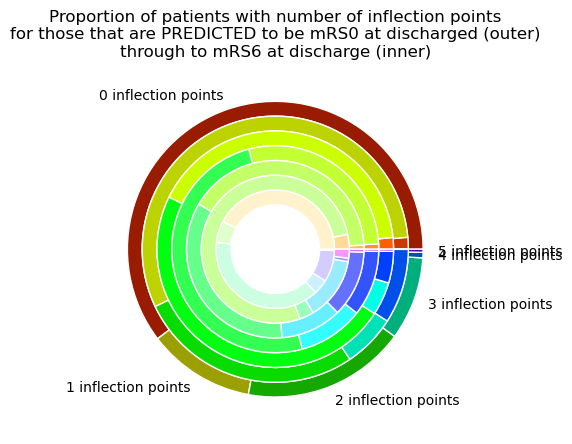

In [126]:
fig, ax = plt.subplots()

size = 0.1

max_infection_points = 6
labels = [(str(i) + " inflection points") for i in range(max_infection_points)]
list_titles = ["mRS0", "mRS1", "mRS2", "mRS3", "mRS4", "mRS5", "mRS6"]

N = n_classes * 1.2
M = 7
cmap = generate_colormap(N*M)
colour_array = np.arange(max_infection_points)

for c in range(n_classes):
    colors = cmap(colour_array  + (M * (c + 2)))

    if c == 0:   
       ax.pie(list_patients_class_predicted[c], radius=1-(size*c), colors=colors, 
              labels=labels, wedgeprops=dict(width=size, edgecolor='w'))
    else:
       ax.pie(list_patients_class_predicted[c], radius=1-(size*c), colors=colors, 
              wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", 
       title=('Proportion of patients with number of inflection points\nfor '
              'those that are PREDICTED to be mRS0 at discharged (outer)\n'
              'through to mRS6 at discharge (inner)'))
plt.show()

Duration to run notebook

In [127]:
str(datetime.timedelta(seconds=(time.time()-start_time)))

'0:00:01.099708'

# EXTRA CODE

Using the default color map (but it did not have enough colours once had many patient cohorts - or for the fifth inflection point group, hence the generated colour map defined above)

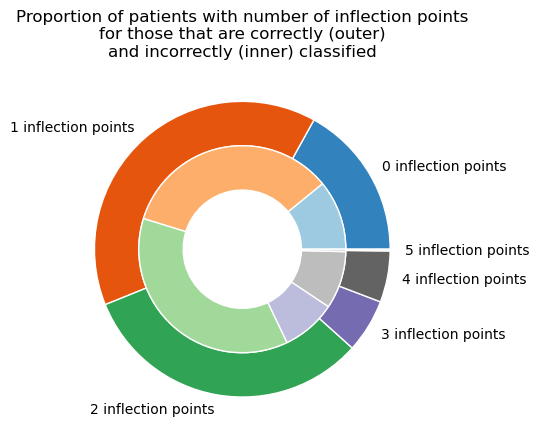

In [128]:
fig, ax = plt.subplots()

size = 0.3

max_infection_points = max(len(list_patients_correct), len(list_patients_incorrect))
labels = [(str(i) + " inflection points")for i in range(max_infection_points)]
list_data = [list_patients_correct, list_patients_incorrect]
list_titles = ["Patients correctly classified", "Patients incorrectly classified"]

cmap = plt.get_cmap("tab20c")
colour_array = np.arange(max_infection_points)
outer_colors = cmap(colour_array * 4)
inner_colors = cmap(colour_array * 4 + 2)


ax.pie(list_data[0], radius=1, colors=outer_colors, labels=labels,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(list_data[1], radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", 
       title=('Proportion of patients with number of inflection points\nfor '
              'those that are correctly (outer)\nand incorrectly (inner) classified'))
plt.show()

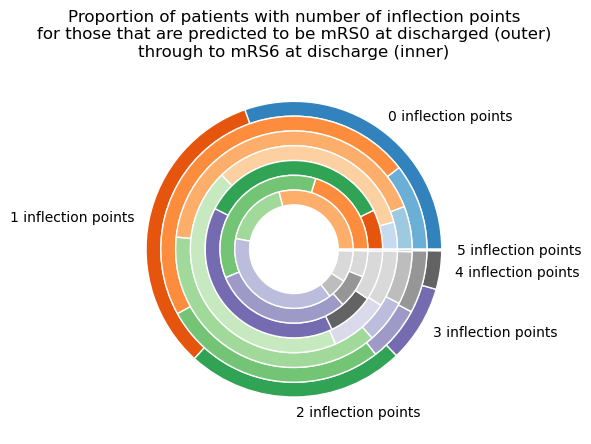

In [129]:
fig, ax = plt.subplots()

size = 0.1

max_infection_points = 6
labels = [(str(i) + " inflection points") for i in range(max_infection_points)]
list_titles = ["mRS0", "mRS1", "mRS2", "mRS3", "mRS4", "mRS5", "mRS6"]

cmap = plt.get_cmap("tab20c")
colour_array = np.arange(max_infection_points)

for c in range(n_classes):
    colors = cmap(colour_array * 4 + c)

    if c == 0:   
       ax.pie(list_patients_class_observed[c], radius=1-(size*c), colors=colors, 
              labels=labels, wedgeprops=dict(width=size, edgecolor='w'))
    else:
       ax.pie(list_patients_class_observed[c], radius=1-(size*c), colors=colors, 
              wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", 
       title=('Proportion of patients with number of inflection points\nfor '
              'those that are predicted to be mRS0 at discharged (outer)\n'
              'through to mRS6 at discharge (inner)'))
plt.show()